In [38]:
import math
import numpy as np
import pandas as pd

import sys
import cv2
import pickle
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

import copy

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# READ AND SCALE INPUT DATA

In [4]:
height = np.reshape(np.fromfile(open("data/LDEM_75S_120M.IMG",
                                     'rb'), np.int16),
                    (7624,7624))
albedo = np.reshape(np.fromfile(open("data/LDAM_50S_1000M_FLOAT.IMG",
                                     'rb'), np.float32),
                    (2532,2532))
LAMP_ratio_albed = np.reshape(np.fromfile(open("data/LAMP_80s_240mpp_ratio_albed_01.img",
                                     'rb'), np.float32),
                    (2501,2501))
LAMP_ratio_brite = np.reshape(np.fromfile(open("data/LAMP_80s_240mpp_ratio_brite_01.img",
                                     'rb'), np.float32),
                    (2501,2501))

In [5]:


height = height[1311:-1311,1311:-1311]
albedo = albedo[966:-966,966:-966]

#height = cv2.resize(height, dsize=LAMP_ratio_albed.shape)
lamp_brite = cv2.resize(LAMP_ratio_brite, dsize=height.shape)
lamp_albed = cv2.resize(LAMP_ratio_albed, dsize=height.shape)
albedo = cv2.resize(albedo, dsize=height.shape)

# FIND POINTS OF INTEREST FOR FINDING WATER

In [6]:
threshold_albedo = 0.35
threshold_lamp_ratio = 1.2

In [7]:
POI = ((lamp_albed > threshold_lamp_ratio) & 
        (lamp_brite > threshold_lamp_ratio) & 
        (albedo > threshold_albedo))

/home/georgesmss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


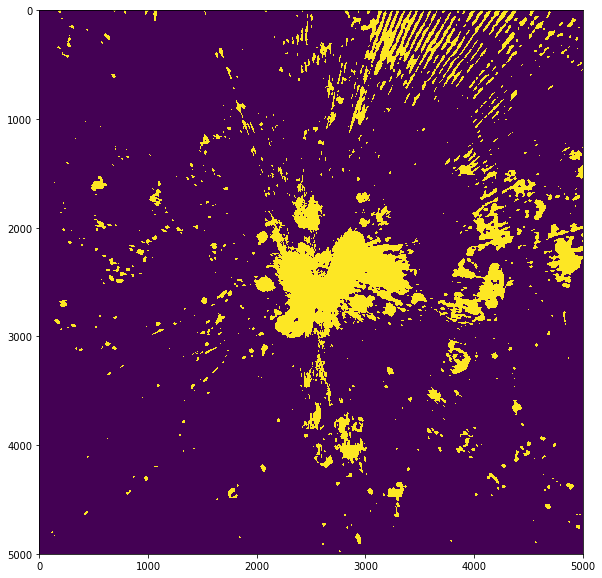

In [8]:
#EXAMPLE OF CRITERIA
image = albedo > threshold_albedo

plt.imshow(image)
plt.savefig("slide2.png")
plt.show()

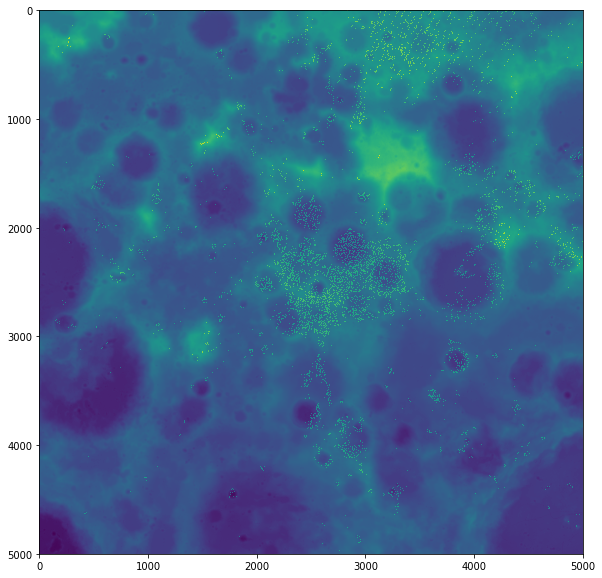

In [9]:
plt.imshow(height + 10000*POI)
plt.savefig("slide1.png")
plt.show()

# FIND LANDING SITES (20 min)

In [10]:
m_per_px = 120
rover_max_dist_m = 24000
rover_max_dist_px = int(rover_max_dist_m / m_per_px) + 1

# SELECTING LANDING SITES

In [11]:
POI_prob = np.load("data/POI_prob_round.npy")
POI_prob.shape
nx = POI_prob.shape[0] - rover_max_dist_px
ny = POI_prob.shape[1] - rover_max_dist_px

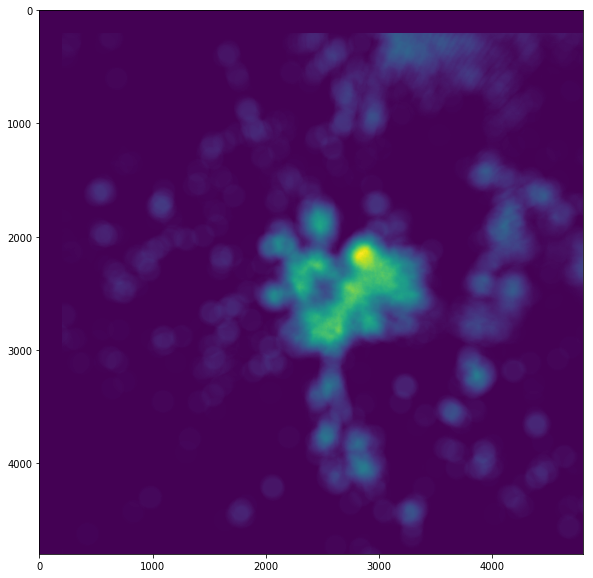

In [12]:
plt.imshow(POI_prob)
plt.savefig("slide3.png")

In [13]:
plt.rcParams['figure.figsize'] = (15.0,15.0)

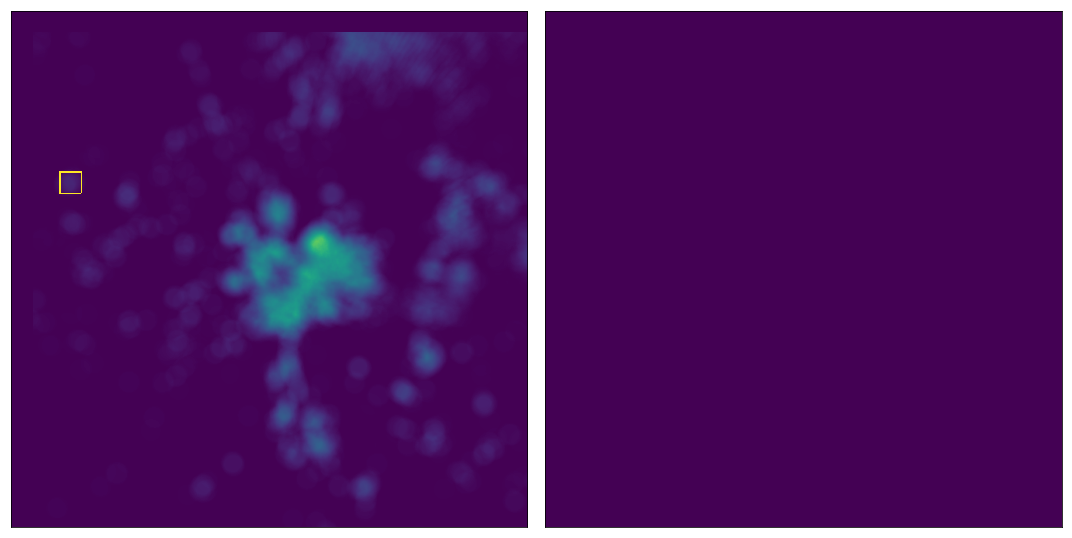

In [14]:
@interact(x = widgets.IntSlider(description='X:', min=1, max=nx, step=50),
          y = widgets.IntSlider(description='Y:', min=1, max=ny, step=50))
def plot(x,y):
    #plt.imshow(POI_prob)

    top_left = (x,y)
    top_left = (1500, 450)
    bottom_right = (top_left[0] + rover_max_dist_px, top_left[1] + rover_max_dist_px)

    POI3 = copy.deepcopy(POI_prob)
    
    #plt.imshow(POI3)

    POI3[top_left[0]:top_left[0]+10,top_left[1]:bottom_right[1]] = 0.4 #upper bar
    POI3[bottom_right[0]:bottom_right[0]+10,top_left[1]:bottom_right[1]] = 0.4 #lower bar
    POI3[top_left[0]:bottom_right[0],top_left[1]:top_left[1]+10] = 0.4 #to the left
    POI3[top_left[0]:bottom_right[0],bottom_right[1]:bottom_right[1]+10] = 0.4 #to the right

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(POI3)
    ax[1].imshow(POI3[x+10:x+rover_max_dist_px-10,y+10:y+rover_max_dist_px-10])

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        
    plt.tight_layout()
    plt.savefig("slide4.png")

In [15]:
top_left = (1500, 450)

# FILTER POI

In [16]:
POI_little = POI[top_left[0]:top_left[0]+rover_max_dist_px,
                top_left[1]:top_left[1]+rover_max_dist_px]
POI_little.shape

(201, 201)

In [17]:
height_little = height[top_left[0]:top_left[0]+rover_max_dist_px,
                        top_left[1]:top_left[1]+rover_max_dist_px]
height_little.shape

(201, 201)

In [18]:
POI_little_filter = copy.deepcopy(POI_little)

In [19]:
for i in range(2,rover_max_dist_px-2):
    for j in range(2,rover_max_dist_px-2):
        POI_little_filter[i,j] =(
                                POI_little[i-1,j-1] & POI_little[i-1,j] & POI_little[i-1,j+1] & 
                                POI_little[i,j-1] & POI_little[i,j] & POI_little[i,j+1] & 
                                POI_little[i+1,j-1] & POI_little[i+1,j] & POI_little[i+1,j+1])
        
                            

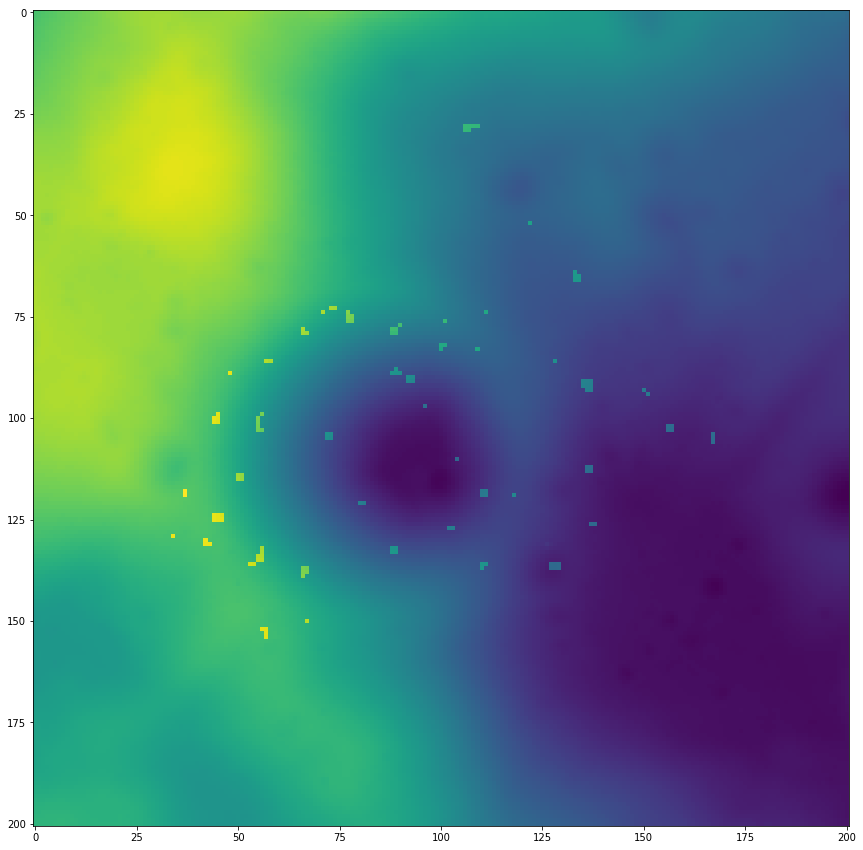

In [20]:
plt.imshow(height_little+2000*POI_little_filter)
plt.savefig("slide5.png")

# BUILD GRAPH

In [21]:
import networkx as nx

In [22]:
G=nx.DiGraph()

In [23]:
for i in np.arange(rover_max_dist_px):
    for j in np.arange(rover_max_dist_px):
        G.add_node((i,j))

In [24]:
def weight_linear(x1, y1, x2, y2):
    height1 = height_little[x1,y1]
    height2 = height_little[x2,y2]
    
    factor = 1.5
    
    dist = np.power(height2 - height1,2) + 120**2
    #dist = np.sqrt(dist)
    
    return dist

def weight_linear2(x1, y1, x2, y2):
    height1 = height_little[x1,y1]
    height2 = height_little[x2,y2]
    
    factor = 1.5
    
    dist = np.power(height2 - height1,2) + 2* np.sqrt(120)**2
    #dist = np.sqrt(dist)
    
    return dist


In [25]:
print(min(np.arange(rover_max_dist_px) - math.floor(rover_max_dist_px/2)))
print(max(np.arange(rover_max_dist_px) - math.floor(rover_max_dist_px/2)))

-100
100


In [26]:
for i in np.arange(rover_max_dist_px)-1:
    for j in np.arange(rover_max_dist_px)-1:
        G.add_edge((i,j),(i,j+1), weight= weight_linear(i,j,i,j+1))
        G.add_edge((i,j+1),(i,j), weight = weight_linear(i,j+1,i,j))
        G.add_edge((i,j),(i+1,j+1), weight = weight_linear2(i,j,i+1,j+1))
        G.add_edge((i+1,j+1),(i,j), weight = weight_linear2(i+1,j+1,i,j))
        G.add_edge((i,j),(i+1,j), weight = weight_linear(i,j,i+1,j))
        G.add_edge((i+1,j),(i,j), weight = weight_linear(i+1,j,i,j))

In [27]:
print(nx.dijkstra_path(G,(50,25),(150,100)))

[(50, 25), (51, 26), (52, 27), (53, 28), (54, 29), (55, 30), (56, 31), (57, 32), (58, 33), (59, 34), (60, 35), (61, 36), (62, 37), (63, 38), (64, 39), (65, 40), (66, 41), (67, 42), (68, 43), (69, 44), (70, 45), (71, 46), (72, 47), (73, 48), (74, 49), (75, 50), (76, 51), (77, 52), (78, 53), (79, 53), (80, 53), (81, 54), (82, 54), (83, 54), (84, 54), (85, 54), (86, 54), (87, 54), (88, 54), (89, 54), (90, 54), (91, 54), (92, 54), (93, 54), (94, 54), (95, 54), (96, 54), (97, 54), (98, 55), (99, 56), (100, 56), (101, 56), (102, 56), (103, 56), (104, 57), (105, 57), (106, 57), (107, 58), (108, 58), (109, 59), (110, 60), (111, 61), (112, 62), (113, 63), (114, 64), (115, 65), (116, 66), (117, 67), (118, 68), (119, 69), (120, 70), (121, 71), (122, 72), (123, 73), (124, 74), (125, 75), (126, 76), (127, 77), (128, 78), (129, 79), (130, 80), (131, 81), (132, 82), (133, 83), (134, 84), (135, 85), (136, 86), (137, 87), (138, 88), (139, 89), (140, 90), (141, 91), (142, 92), (143, 93), (144, 94), (145

In [28]:
def draw_path(x1,y1,x2,y2):
    print(np.max(height_little))
    print(np.min(height_little))
    #path = nx.dijkstra_path(G,(x1,y1),(x2,y2))
    length,path = nx.bidirectional_dijkstra(G,(x1,y1),(x2,y2))
    print(length)
    for node in path:
        plt.plot(node[0], node[1], 'ro-')
    plt.imshow(height_little+2000*POI_little_filter)

1177
-6092
1369010.0


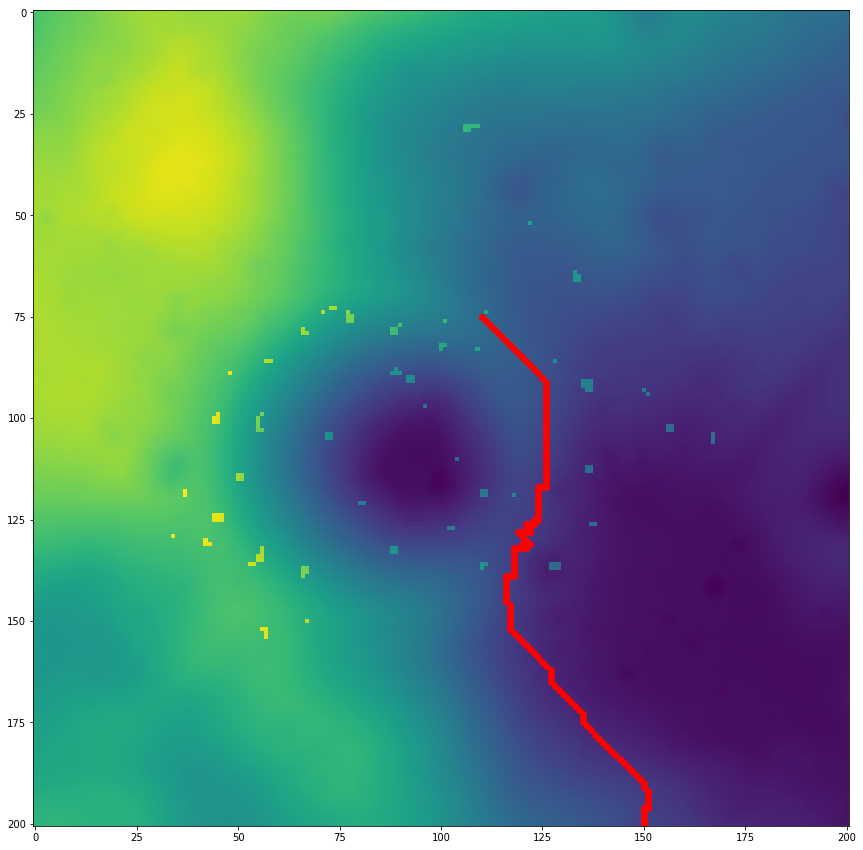

In [29]:
draw_path(150,200,110,75)
plt.savefig("slide6.png")

In [30]:
paths = [(int((rover_max_dist_px-1) / 2),int((rover_max_dist_px-1) / 2))]

#print(POI_little_filter)
for i in range(POI_little_filter.shape[0]):
    for j in range(POI_little_filter.shape[1]):
        if (POI_little_filter[i,j]==True):
            paths.append((i,j))

#print(len(paths))

data= {}

#print(nx.dijkstra_path_length(G,paths[0],paths[0]))
#print(nx.floyd_warshall_numpy(G,nodelist = paths))

df = pd.DataFrame(nx.floyd_warshall_numpy(G,nodelist = paths), columns = paths)
df = df.replace(np.inf,9999999)
#print(df.head())
#df.replace([np.inf, -np.inf], np.nan)
df.to_csv("routing_files/floyd.csv", sep=';')

# BUILD ROUTES

In [31]:
coord_of_POI = list(df.columns)

In [32]:
coord_of_POI = np.array(coord_of_POI)
np.savetxt("routing_files/coord_of_POI.csv", coord_of_POI, delimiter=',', fmt='%f')

In [33]:
n_POI = len(coord_of_POI)

euclidean_distances = np.zeros((n_POI,n_POI))

for i in range(n_POI):
    for j in range(i+1,n_POI):
        distance = math.sqrt(((coord_of_POI[i][0]-coord_of_POI[j][0])**2) +
                        ((coord_of_POI[i][1]-coord_of_POI[j][1])**2))
        #print(i, list_of_POI[i], j,list_of_POI[j],distance)
        euclidean_distances[i,j] = distance
        euclidean_distances[j,i] = distance
np.savetxt("routing_files/euclidean_distances.csv", euclidean_distances, delimiter=',', fmt='%f')

In [34]:
from sklearn.cluster import KMeans

k=math.ceil(len(coord_of_POI)/30)

kmeans = KMeans(n_clusters=k, random_state=0).fit(coord_of_POI[1:])
k

5

In [35]:
clusters = kmeans.labels_ 
clusters = np.append([-1], clusters)
clusters

array([-1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2,
        4,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  1,  2,  0,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  0,  0,  1,  1,  2,  2,  1,  2,  2,  1,  1,  3,  1,  1,  1,  1,
        0,  0,  0,  0,  0,  3,  3,  0,  3,  3,  3,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  3,  3,  0,  0,  0,  0,  0,  3,  3,  0,  3,  3,  0,
        0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  0,  0,  3,  3,  3,  3,  0,
        0,  0,  0,  0,  0,  0,  0])

In [36]:
np.savetxt("routing_files/clusters.csv", clusters, delimiter=',', fmt='%f')

In [37]:
centers = kmeans.cluster_centers_
np.savetxt("routing_files/centers.csv", centers, delimiter=',', fmt='%f')

# RUN JULIA, RUN!

# PLOTTING ROUTES

In [42]:
data = pd.read_csv('routing_files/route_order.txt', header = None)
print (data[0])

0    [100.0 100.0; 121.0 81.0; 121.0 80.0; 137.0 67...
1    [100.0 100.0; 112.0 136.0; 112.0 137.0; 113.0 ...
2    [100.0 100.0; 97.0 96.0; 91.0 93.0; 90.0 93.0;...
3    [100.0 100.0; 110.0 104.0; 118.0 110.0; 119.0 ...
4    [100.0 100.0; 66.0 133.0; 66.0 134.0; 65.0 134...
Name: 0, dtype: object


In [43]:
with open("routing_files/route_order.txt", "r") as ins:
    array = []
    for line in ins:
        array.append(line)
        
print(array[1])

[100.0 100.0; 112.0 136.0; 112.0 137.0; 113.0 137.0; 113.0 136.0; 126.0 137.0; 126.0 138.0; 106.0 167.0; 105.0 167.0; 104.0 167.0; 102.0 157.0; 103.0 157.0; 103.0 156.0; 102.0 156.0; 94.0 151.0; 93.0 150.0; 93.0 137.0; 93.0 136.0; 92.0 136.0; 92.0 137.0; 91.0 137.0; 91.0 136.0; 92.0 135.0; 91.0 135.0; 86.0 128.0]



In [1]:

def routes(day,paths):
    import matplotlib.pyplot as plt
    newstr = paths.replace("[", "")
    newstr = newstr.replace("]", "")
    newstr = newstr.replace("\n", "")
    newstr = newstr.replace(" ", "|")
    #print(newstr)
    tuples = []
    split = newstr.split(';')

    #print(split)

    for t in range(len(split)):
        t = split[t].split("|")
    #print(t)
        if(len(t)>2):
            tuples.append((float(t[1]),float(t[2])))
        else:
            tuples.append((float(t[0]),float(t[1])))
    #print(tuples)
    plt.figure()
    for p1 in range(len(tuples)-1):
        for p2 in range(1,len(tuples)): 
        #print(p1)
            point1 = tuples[p1]
            point2 = tuples[p2]
            x1 = (int(point1[0]),int(point1[1]))
            x2 = (int(point2[0]),int(point2[1]))
            length,path = nx.bidirectional_dijkstra(G,x1,x2)
        
        #print(length)
            for node in path:
                plt.plot(node[0], node[1], 'ro-')

    plt.imshow(height_little+2000*POI_little_filter)
    #plt.xticks([])
    #plt.yticks([])
    plt.savefig('GIF/day'+str(day)+'.png')

In [2]:
for day,paths in enumerate(array):
    routes(day,paths)


NameError: name 'array' is not defined